In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import gdown

## EpiInfer Class

In [ ]:
class EpiInferContact:
    def __init__(self, population_ids, contacts_history, incubation_period=7, infection_duration=7):
        """
        Initialize the EPIINFER-CONTACT system.
        """
        self.population = set(population_ids)
        self.contacts = contacts_history
        self.inc = incubation_period
        self.duration = infection_duration

        # Pre-process contacts for faster lookup
        self.adj = {}
        for day, meets in self.contacts.items():
            self.adj[day] = {pid: set() for pid in self.population}
            for u, v in meets:
                if u in self.adj[day]: self.adj[day][u].add(v)
                if v in self.adj[day]: self.adj[day][v].add(u)

        # Track the latest day for which we have contact data
        # This is crucial for Requirement #1 (Causality)
        self.max_contact_day = max(self.adj.keys()) if self.adj else -1

    def _get_contacts(self, person, day):
        """
        Helper to get contacts. Implements strict causality:
        If 'day' is beyond our known history, assume contacts match
        the last known day (habitual contact assumption).
        """
        target_day = day

        # If the requested day is in the future relative to our data,
        # fallback to the most recent known contact graph.
        if target_day > self.max_contact_day:
            target_day = self.max_contact_day

        if target_day in self.adj and person in self.adj[target_day]:
            return self.adj[target_day][person]
        return set()

    # ==========================================
    # Algorithm 3: findprob
    # ==========================================
    def find_prob(self, bel_asymp, s, p1, d):
        count_encounters = 0
        contacts_of_s = self._get_contacts(s, d)
        for x in contacts_of_s:
            if x in bel_asymp:
                count_encounters += 1
        return 1.0 - (1.0 - p1) ** count_encounters

    # ==========================================
    # Algorithm 2: predict
    # ==========================================
    def predict(self, bel_asymp, bel_susc, p1, d):
        believed_new_asymp = set()
        for s in bel_susc:
            p = self.find_prob(bel_asymp, s, p1, d)
            if random.random() < p:
                believed_new_asymp.add(s)
        return believed_new_asymp

    # ==========================================
    # Algorithm 1: EpiInfer-Core
    # ==========================================
    def contact_infer_core(self, p1, p2, initial_infected_data, start_day, end_day, known_immune=None):
        hist_new_asymp = {}
        hist_new_inf = {}

        # Initialization
        initial_infected_count = len(initial_infected_data)
        # Seeding logic for calibration runs
        if initial_infected_count > 0:
             hist_new_asymp[start_day] = set(initial_infected_data)
        else:
             hist_new_asymp[start_day] = set()

        hist_new_inf[start_day] = set()
        current_immune = set(known_immune) if known_immune else set()

        def get_believed_asymp(curr_day):
            union_set = set()
            for d in range(curr_day - self.inc + 1, curr_day + 1):
                if d in hist_new_asymp:
                    union_set.update(hist_new_asymp[d])
            return union_set

        def get_believed_inf(curr_day):
            union_set = set()
            for d in range(curr_day - self.duration + 1, curr_day + 1):
                if d in hist_new_inf:
                    union_set.update(hist_new_inf[d])
            return union_set

        # Simulation Loop
        for d in range(start_day, end_day):
            bel_asymp_d = get_believed_asymp(d)
            bel_inf_d = get_believed_inf(d)

            non_susc = bel_asymp_d.union(bel_inf_d).union(current_immune)
            bel_susc_d = self.population - non_susc

            new_asymp_next = self.predict(bel_asymp_d, bel_susc_d, p1, d)
            hist_new_asymp[d+1] = new_asymp_next

            source_day = (d + 1) - self.inc
            new_inf_next = set()

            if source_day in hist_new_asymp:
                candidates = hist_new_asymp[source_day]
                for person in candidates:
                    if random.random() < p2:
                        new_inf_next.add(person)

            hist_new_inf[d+1] = new_inf_next

        results = {d: len(s) for d, s in hist_new_inf.items()}
        return results

    # ==========================================
    # Algorithm 4: ContinuousCalibrate (DAMPENED)
    # ==========================================
    def continuous_calibrate(self, training_data, training_days_window,
                             full_history_asymp, full_history_inf,
                             full_recovered_sets, current_day,
                             prev_p1=None, prev_p2=None, dampening_factor=0.002):
        """
        Finds optimal p1, p2 using Grid Search + Inertia Dampening.

        Args:
            prev_p1, prev_p2: The calibrated values from the previous day.
            dampening_factor: Controls how fast parameters change based on RMSE diff.
                              Suggested range: 0.001 to 0.005 for count data.
        """

        # 1. DEFINE EVALUATION WINDOW
        window_start = max(self.inc + self.duration, current_day - training_days_window)
        eval_days = range(window_start, current_day + 1)

        if not eval_days:
            return 0.2, 0.2

        # 2. RUN GRID SEARCH (To find the "Target" v2)
        best_rmse_candidate = float('inf')
        target_p1, target_p2 = 0.5, 0.5

        # Coarse Grid
        p1_candidates = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        p2_candidates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

        for p1 in p1_candidates:
            for p2 in p2_candidates:
                rmse = self._calculate_rmse_for_params(
                    p1, p2, eval_days,
                    full_history_asymp, full_history_inf,
                    full_recovered_sets, training_data
                )
                if rmse < best_rmse_candidate:
                    best_rmse_candidate = rmse
                    target_p1 = p1
                    target_p2 = p2

        # Fine Tuning (Narrow search around the best coarse candidate)
        delta = 0.05
        fine_p1_range = [x for x in [target_p1-delta, target_p1, target_p1+delta] if 0 < x < 1]
        fine_p2_range = [x for x in [target_p2-delta, target_p2, target_p2+delta] if 0 < x < 1]

        for p1 in fine_p1_range:
            for p2 in fine_p2_range:
                rmse = self._calculate_rmse_for_params(
                    p1, p2, eval_days,
                    full_history_asymp, full_history_inf,
                    full_recovered_sets, training_data
                )
                if rmse < best_rmse_candidate:
                    best_rmse_candidate = rmse
                    target_p1 = p1
                    target_p2 = p2

        # 3. APPLY DAMPENING FORMULA
        # If this is the first day (no history), just return the candidate
        if prev_p1 is None or prev_p2 is None:
            return target_p1, target_p2

        # Calculate RMSE for the OLD parameters on the CURRENT window
        rmse_prev = self._calculate_rmse_for_params(
            prev_p1, prev_p2, eval_days,
            full_history_asymp, full_history_inf,
            full_recovered_sets, training_data
        )

        # Formula: v1 + (v2 - v1) * (RMSE_v1 - RMSE_v2) * dampening
        # Note: RMSE_v1 (rmse_prev) should generally be >= RMSE_v2 (best_rmse_candidate)
        rmse_diff = max(0, rmse_prev - best_rmse_candidate)

        # Calculate new dampened values
        new_p1 = prev_p1 + (target_p1 - prev_p1) * rmse_diff * dampening_factor
        new_p2 = prev_p2 + (target_p2 - prev_p2) * rmse_diff * dampening_factor

        # CLAMPING to ensure validity
        new_p1 = max(0.01, min(0.99, new_p1))
        new_p2 = max(0.01, min(0.99, new_p2))

        return new_p1, new_p2

    def _calculate_rmse_for_params(self, p1, p2, eval_days, h_asymp, h_inf, h_rec, training_data):
        """Helper to calculate RMSE for a specific (p1, p2) pair."""
        sq_err_sum = 0
        count = 0

        for d in eval_days:
            # Setup History
            h_asymp_d = {}
            h_inf_d = {}
            for k in range(1, self.inc + self.duration + 2):
                prev = d - k
                if prev in h_asymp: h_asymp_d[prev] = h_asymp[prev]
                if prev in h_inf: h_inf_d[prev] = h_inf[prev]

            rec_d = h_rec.get(d, set())

            # Run Single Step Prediction
            res = self.contact_infer_core_with_history(
                p1, p2,
                h_asymp_d, h_inf_d,
                d - 1, d,
                rec_d
            )

            if d in res and d in training_data:
                pred = res[d]
                actual = training_data[d]
                sq_err_sum += (pred - actual) ** 2
                count += 1

        if count == 0: return float('inf')
        return math.sqrt(sq_err_sum / count)

In [ ]:
# ==========================================
# 2. EXTENSION FOR ROLLING HISTORY
# ==========================================
class EpiInferContactRolling(EpiInferContact):
    def contact_infer_core_with_history(self, p1, p2, history_asymp, history_inf, start_day, end_day, known_immune):
        # Initialize with passed history
        hist_new_asymp = history_asymp.copy()
        hist_new_inf = history_inf.copy()
        current_immune = set(known_immune) if known_immune else set()

        def get_believed_asymp(curr_day):
            union_set = set()
            for d in range(curr_day - self.inc + 1, curr_day + 1):
                if d in hist_new_asymp: union_set.update(hist_new_asymp[d])
            return union_set

        def get_believed_inf(curr_day):
            union_set = set()
            for d in range(curr_day - self.duration + 1, curr_day + 1):
                if d in hist_new_inf: union_set.update(hist_new_inf[d])
            return union_set

        results = {}
        for d in range(start_day, end_day):
            bel_asymp_d = get_believed_asymp(d)
            bel_inf_d = get_believed_inf(d)

            # Determine recovered individuals dynamically
            recovered_d = set()
            for past_d, inf_set in hist_new_inf.items():
                if past_d + self.duration <= d: recovered_d.update(inf_set)

            non_susc = bel_asymp_d.union(bel_inf_d).union(current_immune).union(recovered_d)
            bel_susc_d = self.population - non_susc

            # PREDICT STEP
            # Calls self.predict -> self.find_prob -> self._get_contacts
            # _get_contacts handles the fallback if 'd' is in the future
            new_asymp_next = self.predict(bel_asymp_d, bel_susc_d, p1, d)
            hist_new_asymp[d+1] = new_asymp_next

            source_day = (d + 1) - self.inc
            new_inf_next = set()
            if source_day in hist_new_asymp:
                candidates = hist_new_asymp[source_day]
                for person in candidates:
                    if random.random() < p2: new_inf_next.add(person)
            hist_new_inf[d+1] = new_inf_next

        # Tally active cases
        for d in range(start_day + 1, end_day + 1):
             active = set()
             for lookback in range(d - self.duration + 1, d + 1):
                 if lookback in hist_new_inf: active.update(hist_new_inf[lookback])
             results[d] = len(active)
        return results

In [ ]:
gdown.download('https://drive.google.com/file/d/1TNtEpn1CtFVwAt4Eyale8SdMvg7n0-0f/view?usp=drive_link', fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1TNtEpn1CtFVwAt4Eyale8SdMvg7n0-0f
From (redirected): https://drive.google.com/uc?id=1TNtEpn1CtFVwAt4Eyale8SdMvg7n0-0f&confirm=t&uuid=151b1329-ac9c-4cd2-a622-a3d19b427985
To: /content/simulated_data.zip
100%|██████████| 78.9M/78.9M [00:01<00:00, 46.0MB/s]


'simulated_data.zip'

In [ ]:
!ls -ltrh

total 76M
drwxr-xr-x 1 root root 4.0K Jan 16 14:24 sample_data
-rw-r--r-- 1 root root  76M Feb  3 16:00 simulated_data.zip


In [ ]:
!unzip simulated_data.zip

Archive:  simulated_data.zip
   creating: simulated_data/
  inflating: simulated_data/.DS_Store  
   creating: simulated_data/p1_0.12_p2_0.05/
  inflating: simulated_data/p1_0.12_p2_0.05/.DS_Store  
  inflating: simulated_data/p1_0.12_p2_0.05/individual_day_state.csv  
  inflating: simulated_data/p1_0.12_p2_0.05/repeated_meetings_by_day_with_age.csv  
  inflating: simulated_data/p1_0.12_p2_0.05/states_total.csv  
  inflating: simulated_data/p1_0.12_p2_0.05/timed_edges.csv  
   creating: simulated_data/p1_0.12_p2_0.1/
  inflating: simulated_data/p1_0.12_p2_0.1/.DS_Store  
  inflating: simulated_data/p1_0.12_p2_0.1/individual_day_state.csv  
  inflating: simulated_data/p1_0.12_p2_0.1/repeated_meetings_by_day_with_age.csv  
  inflating: simulated_data/p1_0.12_p2_0.1/states_total.csv  
  inflating: simulated_data/p1_0.12_p2_0.1/timed_edges.csv  
   creating: simulated_data/p1_0.12_p2_0.2/
  inflating: simulated_data/p1_0.12_p2_0.2/.DS_Store  
  inflating: simulated_data/p1_0.12_p2_0.2/indi

In [ ]:
!ls -ltr simulated_data/

total 48
drwxrwxrwx 2 root root 4096 Feb  3 15:53 p1_0.2_p2_0.05
drwxrwxrwx 2 root root 4096 Feb  3 15:53 p1_0.2_p2_0.2
drwxrwxrwx 2 root root 4096 Feb  3 15:53 p1_0.2_p2_0.1
drwxrwxrwx 2 root root 4096 Feb  3 15:53 p1_0.15_p2_0.2
drwxrwxrwx 2 root root 4096 Feb  3 15:53 p1_0.12_p2_0.2
drwxrwxrwx 2 root root 4096 Feb  3 15:53 p1_0.25_p2_0.2
drwxrwxrwx 2 root root 4096 Feb  3 15:53 p1_0.25_p2_0.1
drwxrwxrwx 2 root root 4096 Feb  3 15:53 p1_0.25_p2_0.05
drwxrwxrwx 2 root root 4096 Feb  3 15:53 p1_0.15_p2_0.05
drwxrwxrwx 2 root root 4096 Feb  3 15:53 p1_0.12_p2_0.1
drwxrwxrwx 2 root root 4096 Feb  3 15:53 p1_0.12_p2_0.05
drwxrwxrwx 2 root root 4096 Feb  3 15:54 p1_0.15_p2_0.1


## SETUP & MAIN EXECUTION LOOP

Loading data from simulated_data/p1_0.2_p2_0.2 for Ground Truth...
Starting Rolling Prediction with Continuous Calibration...
Day 25 | Calibrated p1=0.20, p2=0.20
Day 30 | Calibrated p1=0.23, p2=0.20
Day 35 | Calibrated p1=0.20, p2=0.20
Day 40 | Calibrated p1=0.20, p2=0.20
Day 45 | Calibrated p1=0.20, p2=0.20
Day 50 | Calibrated p1=0.21, p2=0.20
Day 55 | Calibrated p1=0.23, p2=0.20
Day 60 | Calibrated p1=0.21, p2=0.20
Day 65 | Calibrated p1=0.20, p2=0.20
Day 70 | Calibrated p1=0.20, p2=0.20
Day 75 | Calibrated p1=0.20, p2=0.20
Day 80 | Calibrated p1=0.20, p2=0.20
Day 85 | Calibrated p1=0.22, p2=0.20
Day 90 | Calibrated p1=0.21, p2=0.20
Day 95 | Calibrated p1=0.21, p2=0.20


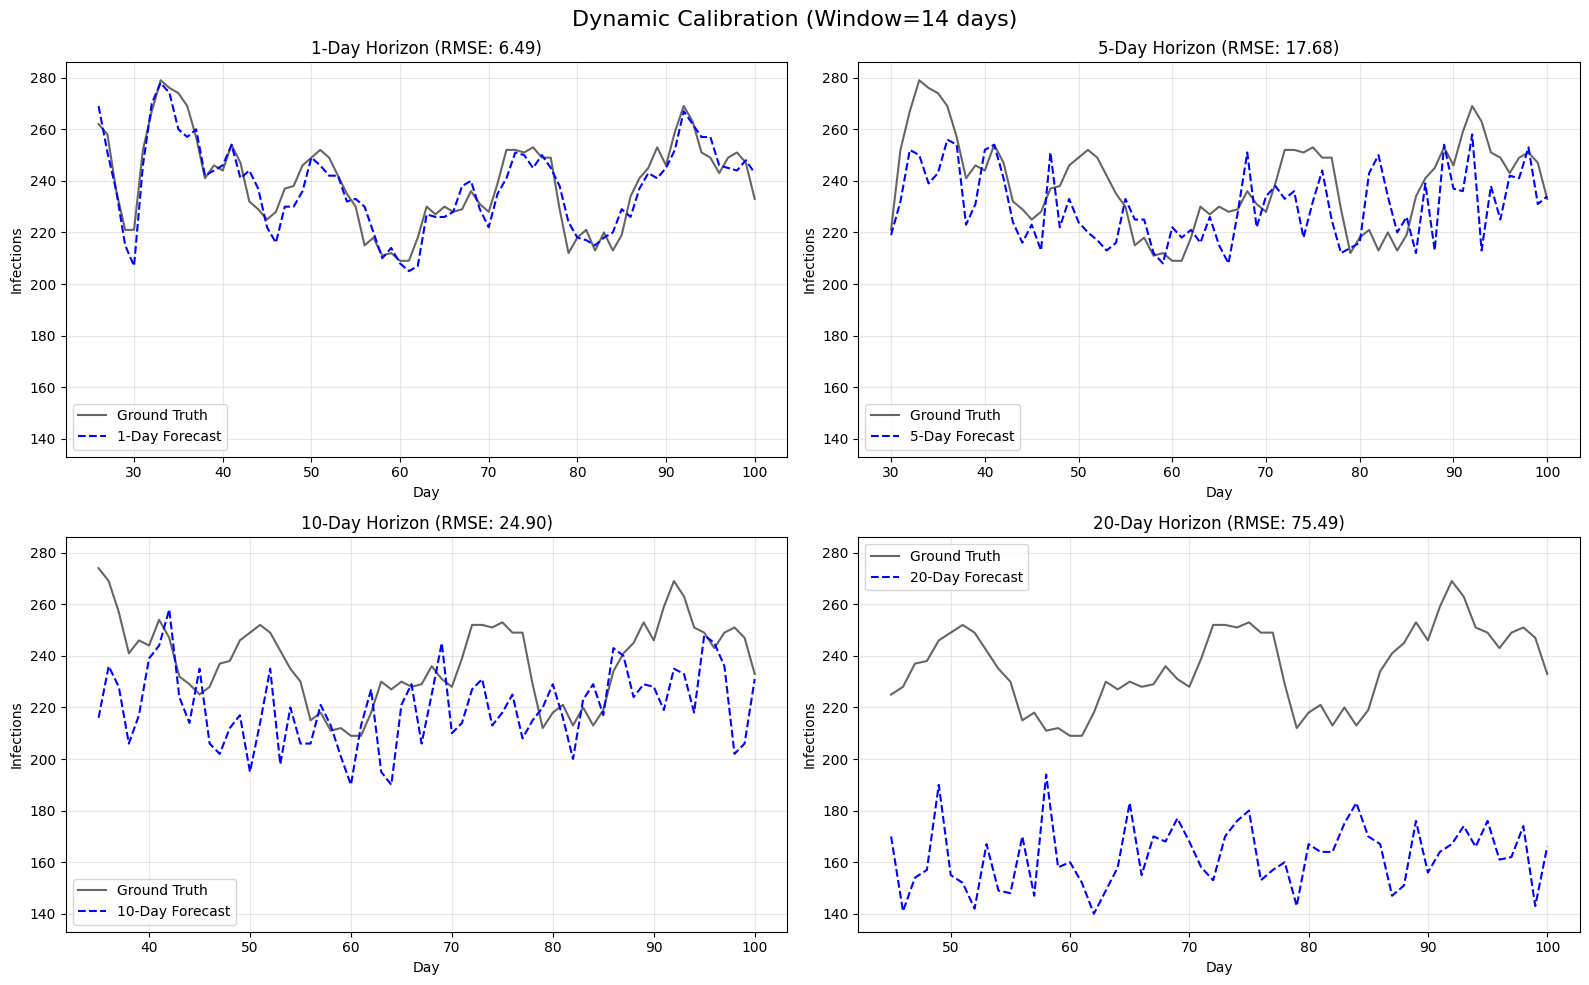

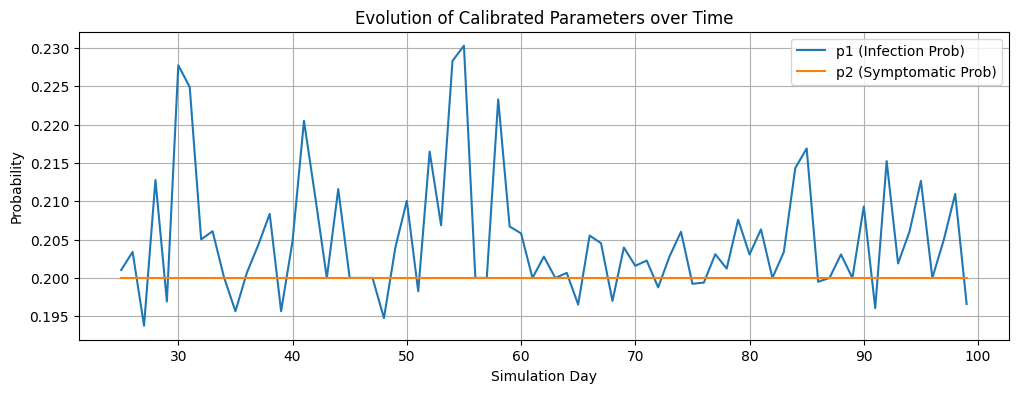

In [ ]:
# --- Configuration ---
# p = [(0.2, 0.2), (0.25, 0.1), (0.12, 0.1), (0.15, 0.05), (0.2, 0.1), (0.15, 0.1), (0.2, 0.05), (0.12, 0.05), (0.25, 0.05), (0.15, 0.2), (0.25, 0.2), (0.12, 0.2)]
p = [(0.2, 0.2)]
horizons = [1, 5, 10, 20]
start_eval = 25
max_day = 100
total_population = 2000
calibration_window = 14  # Lookback days for calibration

for p1, p2 in p:
    # Use a single output path since parameters are now dynamic
    base_path = 'simulated_data/p1_'+str(p1)+'_p2_'+str(p2)
    print(f"Loading data from {base_path} for Ground Truth...")

    # --- 1. Load & Preprocess Ground Truth ---
    try:
        df_status = pd.read_csv(f'{base_path}/individual_day_state.csv')
        df_contacts = pd.read_csv(f'{base_path}/timed_edges.csv')
    except FileNotFoundError:
        raise FileNotFoundError("Data files not found. Please check paths.")

    # Generate Ground Truth Table (Active Infected)
    df_gt = df_status.groupby(['day', 'state']).size().unstack(fill_value=0).reset_index()
    if 'infected' not in df_gt.columns: df_gt['infected'] = 0
    ground_truth_dict = dict(zip(df_gt['day'], df_gt['infected']))

    # Extract Transitions (New Asymptomatic / New Infected)
    state_sets = {}
    all_days = sorted(df_status['day'].unique())
    for d in all_days:
        day_data = df_status[df_status['day'] == d]
        state_sets[d] = {
            'asymptomatic': set(day_data[day_data['state'] == 'asymptomatic']['individual']),
            'infected': set(day_data[day_data['state'] == 'infected']['individual']),
            'recovered': set(day_data[day_data['state'] == 'recovered']['individual'])
        }

    global_new_asymp = {}
    global_new_inf = {}
    for d in all_days:
        curr_A = state_sets[d]['asymptomatic']
        curr_I = state_sets[d]['infected']
        if d == 0:
            global_new_asymp[0] = curr_A
            global_new_inf[0] = curr_I
        else:
            prev_A = state_sets[d-1]['asymptomatic']
            prev_I = state_sets[d-1]['infected']
            global_new_asymp[d] = curr_A - prev_A
            global_new_inf[d] = curr_I - prev_I

    # Load Contacts into a Master Dictionary
    master_contacts = {}
    for day, group in df_contacts.groupby('day'):
        master_contacts[day] = list(zip(group['i'], group['j']))

    # --- 2. Main Rolling Loop ---
    rows = []
    current_p1 = p1  # Starting guess
    current_p2 = p2
    calib_history = []
    damp_factor = 0.01 # Suggest starting small: 0.001 to 0.005

    print("Starting Rolling Prediction with Continuous Calibration...")

    for current_day in range(start_eval, max_day):
        # -----------------------------------------------------
        # Requirement 1: Enforce Causality on Contacts
        # -----------------------------------------------------
        # We only expose contacts up to current_day.
        # The EpiInferContact class handles the fallback logic
        # for future days > current_day inside _get_contacts.

        # Slice contacts to history only
        current_contacts_view = {d: master_contacts[d] for d in master_contacts if d <= current_day}

        # -----------------------------------------------------
        # Requirement 2: Continuous Calibration (One-Step Mode)
        # -----------------------------------------------------

        # 1. Prepare Calibration Ground Truth
        # We pass the full dictionaries to the function, so we don't need to slice here
        # Just need to pass the window size.


        calib_window_days = 14
        calib_end_day = current_day
        calib_start_day = max(0, current_day - calib_window_days)

        # 1. Prepare Calibration Ground Truth
        calib_training_data = {
            d: ground_truth_dict.get(d, 0)
            for d in range(calib_start_day, calib_end_day + 1)
        }

        # calib_training_data = ground_truth_dict # or Pass full dict

        # 2. Run Calibration
        # Pass the GLOBAL history dicts (global_new_asymp, etc.)
        # The function will internally slice what it needs for the window.

        # Recovered sets map needed
        recovered_sets_map = {d: state_sets[d]['recovered'] for d in state_sets}

        model_calib = EpiInferContactRolling(list(range(total_population)), current_contacts_view, 7, 7)

        # Run Calibration with Dampening
        # Notice we pass current_p1, current_p2 as 'prev' values
        best_p1, best_p2 = model_calib.continuous_calibrate(
            training_data=calib_training_data,
            training_days_window=calib_window_days,
            full_history_asymp=global_new_asymp,
            full_history_inf=global_new_inf,
            full_recovered_sets=recovered_sets_map,
            current_day=current_day,
            prev_p1=current_p1,  # <--- PASSING PREVIOUS STATE
            prev_p2=current_p2,  # <--- PASSING PREVIOUS STATE
            dampening_factor=damp_factor
        )

        calib_history.append({'day': current_day, 'p1': best_p1, 'p2': best_p2})

        # -----------------------------------------------------
        # Prediction Step (Using Calibrated Parameters)
        # -----------------------------------------------------

        # Prepare History Buffers (Ground truth up to now)
        h_asymp = {}
        h_inf = {}
        for k in range(8): # Need enough history for incubation lookback
            lookback = current_day - k
            if lookback in global_new_asymp: h_asymp[lookback] = global_new_asymp[lookback]
            if lookback in global_new_inf: h_inf[lookback] = global_new_inf[lookback]

        seed_rec = state_sets[current_day]['recovered']

        # Instantiate Predictor (same contact view)
        model_pred = EpiInferContactRolling(list(range(total_population)), current_contacts_view, 7, 7)

        # Predict into future (up to max horizon)
        max_h = max(horizons)
        res = model_pred.contact_infer_core_with_history(
            best_p1, best_p2, h_asymp, h_inf, current_day, min(current_day + max_h + 1, max_day), seed_rec
        )

        # Store Results
        for h in horizons:
            tgt = current_day + h
            if tgt in res:
                rows.append({
                    'horizon': h,
                    'current_day': current_day,
                    'target_day': tgt,
                    'predicted': res[tgt],
                    'actual': ground_truth_dict.get(tgt, 0),
                    'p1_used': best_p1,
                    'p2_used': best_p2
                })

        if current_day % 5 == 0:
            print(f"Day {current_day} | Calibrated p1={best_p1:.2f}, p2={best_p2:.2f}")

    df_res = pd.DataFrame(rows)

    # ==========================================
    # 3. PLOTTING RESULTS
    # ==========================================

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    fig.suptitle(f'Dynamic Calibration (Window={calibration_window} days)', fontsize=16)

    # Calculate global Y limits across all horizons
    all_actual = df_res['actual'].values
    all_predicted = df_res['predicted'].values
    y_min = min(all_actual.min(), all_predicted.min())
    y_max = max(all_actual.max(), all_predicted.max())

    # Add some padding (optional)
    y_range = y_max - y_min
    y_min -= 0.05 * y_range
    y_max += 0.05 * y_range

    if not df_res.empty:
        for idx, h in enumerate(horizons):
            ax = axes[idx]
            sub = df_res[df_res['horizon'] == h]
            if not sub.empty:
                ax.plot(sub['target_day'], sub['actual'], label='Ground Truth', color='black', alpha=0.6)
                ax.plot(sub['target_day'], sub['predicted'], label=f'{h}-Day Forecast', color='blue', linestyle='--')

                rmse = np.sqrt(((sub['predicted'] - sub['actual'])**2).mean())
                ax.set_title(f"{h}-Day Horizon (RMSE: {rmse:.2f})")
                ax.legend()
                ax.set_ylim(y_min, y_max)
                ax.set_xlabel("Day")
                ax.set_ylabel("Infections")
                ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Plot Parameter Evolution
        df_params = pd.DataFrame(calib_history)
        plt.figure(figsize=(12, 4))
        plt.plot(df_params['day'], df_params['p1'], label='p1 (Infection Prob)')
        plt.plot(df_params['day'], df_params['p2'], label='p2 (Symptomatic Prob)')
        plt.title("Evolution of Calibrated Parameters over Time")
        plt.xlabel("Simulation Day")
        plt.ylabel("Probability")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No results generated.")